Training an LSTM Model to predict Stock Price Movement 

In [2]:
# pip install torch

In [3]:
# pip install alpha_vantage

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

All libraries loaded


Alpha Vantage is a service that provides real-time and historical stock market data, including various financial metrics, technical indicators, and exchange rates. The data is accessible through a suite of APIs, making it easy for developers and analysts to integrate financial data into their applications, models, and analyses.

PDFH4Z4YZ4QKFH5L

In [5]:
config = {
    "alpha_vantage": {
        "key": "PDFH4Z4YZ4QKFH5L", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Data Preparation: Acquiring financial market data from Alpha Vantage

we will query the Alpha Vantage stock data API via a popular Python wrapper. For this project, we will obtain over 20 years of daily close prices for IBM from November 1999 to June 07, 2024.

In [6]:
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date]['4. close']) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

Number data points 6190 from 1999-11-01 to 2024-06-07


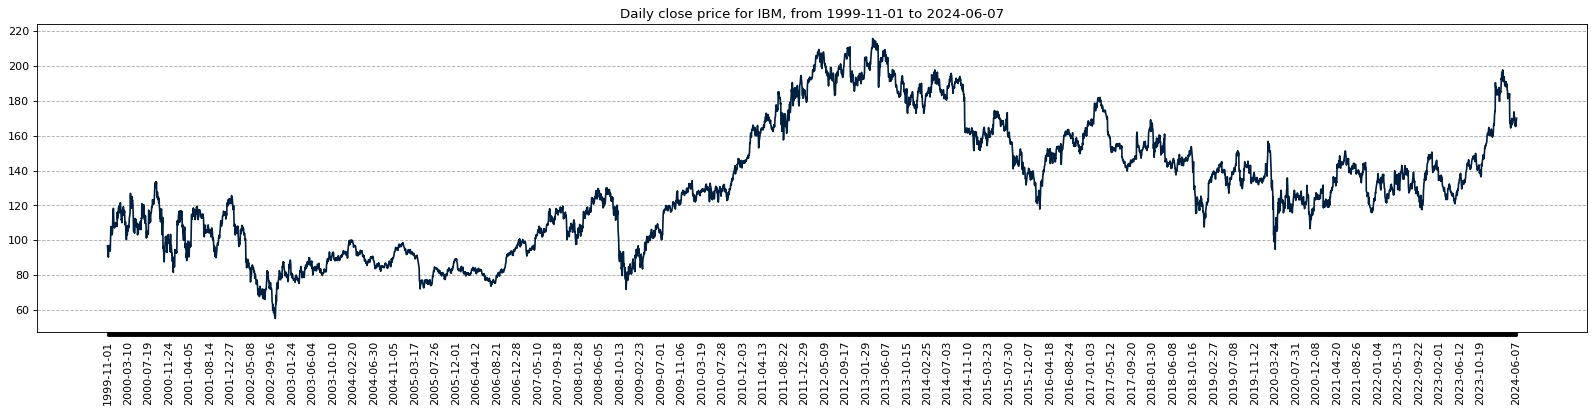

In [7]:
# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()

Data Prep: Normalizing Raw Data

Machine learning algorithms (such as our LSTM algorithm) that use gradient descent as the optimization technique require data to be scaled. This is due to the fact that the feature values in the model will affect the step size of the gradient descent, potentially skewing the LSTM model in unexpected ways.

Since stock prices can range from tens to hundreds and thousands - $40 to $160 in the case of IBM - we will perform normalization on the stock prices to standardize the range of these values before feeding the data to the LSTM model. The following code snippet rescales the data to have a mean of 0 and the standard deviation is 1.

In [8]:
from sklearn.preprocessing import StandardScaler

# Reshape data for normalization
data_close_price = data_close_price.reshape(-1, 1)

# normalize
scaler = StandardScaler() #  MinMaxScaler() can also be used 
normalized_data_close_price = scaler.fit_transform(data_close_price)

Data preparation: generating training and validation datasets

In [9]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])


In [10]:
# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

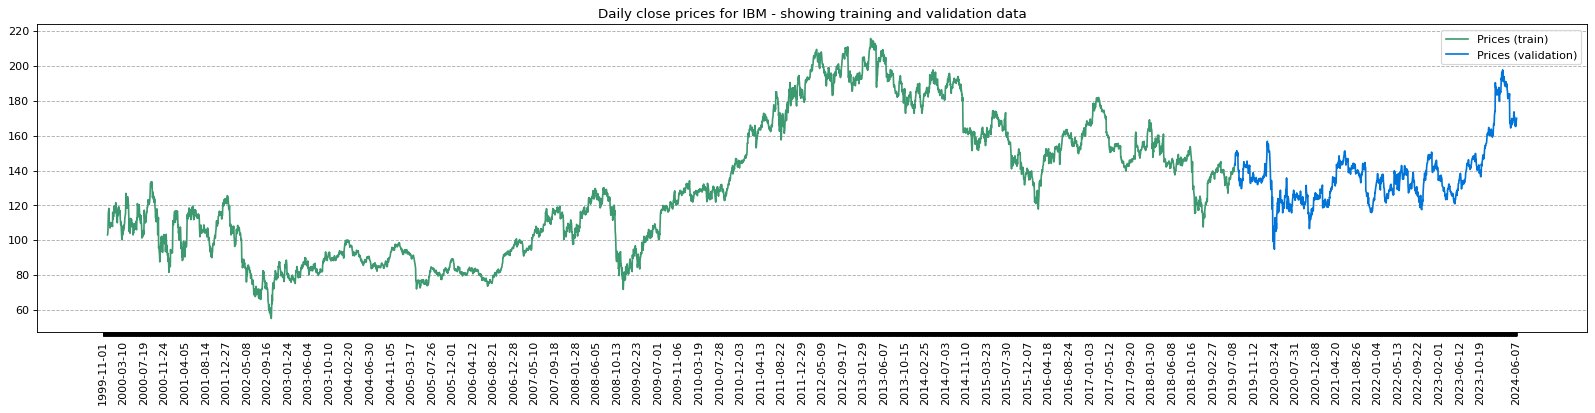

In [11]:
# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

# Inverse transform and flatten
data_y_train_inv = scaler.inverse_transform(data_y_train).flatten()
data_y_val_inv = scaler.inverse_transform(data_y_val).flatten()


# Assign values to plot arrays
to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = data_y_train_inv
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = data_y_val_inv

# Replace zeros with None for plotting
to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

## plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()


We will train our models using the PyTorch framework, a machine learning library written in Python. At the heart of PyTorch's data loading utility is the DataLoader class, an efficient data generation scheme that leverages the full potential of your computer's Graphics Processing Unit (GPU) during the training process where applicable. DataLoader requires the Dataset object to define the loaded data. Dataset is a map-style dataset that implements the __getitem__() and __len__() protocols, and represents a map from indices to data samples.

In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (4936, 20, 1) (4936, 1)
Validation data shape (1234, 20, 1) (1234, 1)


Defining the LSTM Model

With the training and evaluation data now fully normalized and prepared, we are ready to build our LSTM model!

As mentioned before, LSTM is a specialized artificial neural network architecture that can "memorize" patterns from historical sequences of data and extrapolate such patterns for future events. Specifically, it belongs to a group of artificial neural networks called Recurring Neural Networks (RNNs).

LSTM is a popular artificial neural network because it manages to overcome many technical limitations of RNNs. For example, RNNs fail to learn when the data sequence is greater than 5 to 10 due to the vanishing gradients problem, where the gradients are vanishingly small, effectively preventing the model from learning. LSTMs can learn long sequences of data by enforcing constant error flow through self-connected hidden layers, which contain memory cells and corresponding gate units.

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

Model Training 

In [14]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

In [15]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)


In [16]:
model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)


loss train gives an idea of how well the model is learning, while loss test shows how well the model generalizes the validation dataset. 

In [17]:
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


c:\Users\prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18])). This will likely lead to incorre

Epoch[1/100] | loss train:1.535844, test:0.092341 | lr:0.010000
Epoch[2/100] | loss train:1.572975, test:0.113820 | lr:0.010000
Epoch[3/100] | loss train:1.551077, test:0.092756 | lr:0.010000
Epoch[4/100] | loss train:1.684247, test:0.103900 | lr:0.010000
Epoch[5/100] | loss train:1.501756, test:0.102030 | lr:0.010000
Epoch[6/100] | loss train:1.544105, test:0.082337 | lr:0.010000
Epoch[7/100] | loss train:1.500079, test:0.094650 | lr:0.010000
Epoch[8/100] | loss train:1.606096, test:0.101378 | lr:0.010000
Epoch[9/100] | loss train:1.482534, test:0.105266 | lr:0.010000
Epoch[10/100] | loss train:1.593824, test:0.091089 | lr:0.010000
Epoch[11/100] | loss train:1.576613, test:0.099939 | lr:0.010000
Epoch[12/100] | loss train:1.676722, test:0.086741 | lr:0.010000
Epoch[13/100] | loss train:1.508160, test:0.108056 | lr:0.010000
Epoch[14/100] | loss train:1.570743, test:0.096524 | lr:0.010000
Epoch[15/100] | loss train:1.532512, test:0.108892 | lr:0.010000
Epoch[16/100] | loss train:1.64180

In [28]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))


In [29]:
# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))


In [35]:

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

# Inverse transform and flatten
data_y_train_inv = scaler.inverse_transform(data_y_train).flatten()
data_y_val_inv = scaler.inverse_transform(data_y_val).flatten()


# Assign values to plot arrays
to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = data_y_train_inv
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = data_y_val_inv

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)


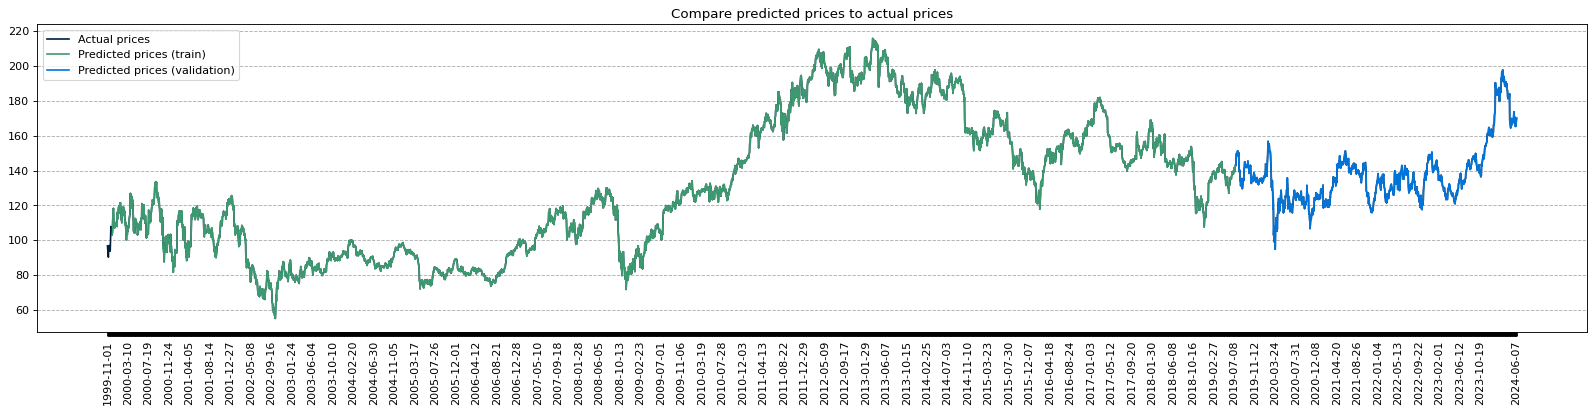

In [36]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [47]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices
# Inverse transform and flatten



to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val).flatten()
to_plot_predicted_val = scaler.inverse_transform(predicted_val).flatten()
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]


# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[-0.03868211 -0.03862409 -0.03877189 ... -0.02841039 -0.02708753
 -0.02655293].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.